In [1]:
# Import necessary packages

%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn import neighbors
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold
from scipy.stats import norm
from operator import itemgetter
from sklearn.model_selection import cross_val_score

In [2]:
# Import the datasets

dfHistorical = pd.read_csv('historical-mvps.csv')
dfCurrent = pd.read_csv('current-mvp-ladder.csv')

In [3]:
# Preview the historical dataset

dfHistorical.head()

,Rank,Player,Age,Tm,Pts Won,Pts Max,Share,G,Team Wins,Overall Seed,...,3P%,FT%,WS,WS/48,VORP,BPM,G-Lockout,Wins-Lockout,WS-Lockout,VORP-Lockout
0,1,Kareem Abdul-Jabbar,32,LAL,147.0,221,0.665,82.0,60.0,2,...,0.000,0.765,14.8,0.227,6.8,6.7,NaN,NaN,NaN,NaN
1,2,Julius Erving,29,PHI,31.5,221,0.143,78.0,59.0,3,...,0.200,0.787,12.5,0.213,6.5,7.2,NaN,NaN,NaN,NaN
2,3,George Gervin,27,SAS,19.0,221,0.086,78.0,41.0,10,...,0.314,0.852,10.6,0.173,3.1,2.2,NaN,NaN,NaN,NaN
3,4,Larry Bird,23,BOS,15.0,221,0.068,82.0,61.0,1,...,0.406,0.836,11.2,0.182,5.4,5.3,NaN,NaN,NaN,NaN
4,5,Tiny Archibald,31,BOS,2.0,221,0.009,80.0,61.0,1,...,0.222,0.830,8.9,0.148,1.5,0.0,NaN,NaN,NaN,NaN


# Histogram of share

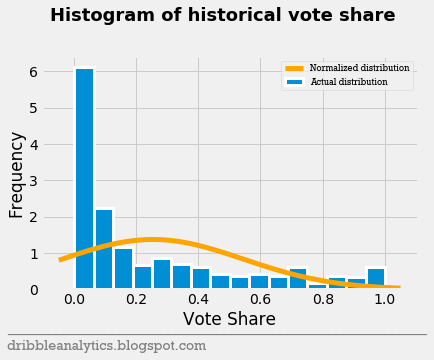

In [4]:
plt.style.use('fivethirtyeight')

voteHist, ax = plt.subplots()

ax.hist(dfHistorical['Share'], bins = 16, edgecolor = 'white', linewidth = 3, normed = True, label = "Actual distribution")
voteHist.suptitle("Histogram of historical vote share", weight = 'bold', size = 18, y = 1.05)
ax.set_xlabel("Vote Share")
ax.set_ylabel("Frequency")

overall_mean = dfHistorical['Share'].mean()
overall_std = dfHistorical['Share'].std()

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, overall_mean, overall_std)
ax.plot(x, p, 'k', linewidth=5, color='orange', label = "Normalized distribution")

ax.legend(loc='best', prop={'size': 9, "family": "Rockwell"})

voteHist.text(x = 0, y = -0.08,
    s = '____________________________________________________________',
    fontsize = 14, color = 'grey', horizontalalignment='left')

voteHist.text(x = 0, y = -.14,
    s = 'dribbleanalytics.blogspot.com                     ',
    fontsize = 14, fontname = 'Rockwell', color = 'grey', horizontalalignment='left')

voteHist.savefig('vote-hist.png', dpi = 400, bbox_inches = 'tight')

# Create models

In [5]:
train, test = train_test_split(dfHistorical, test_size = 0.25, random_state = 10)

xtrain = train[['Team Wins', 'Overall Seed', 'PTS', 'TRB', 'AST', 'FG%', 'VORP', 'WS']]
ytrain = train[['Share']]

xtest = test[['Team Wins', 'Overall Seed', 'PTS', 'TRB', 'AST', 'FG%', 'VORP', 'WS']]
ytest = test[['Share']]

In [6]:
# Create function that gives accuracy scores for each model

def scores(y, model):
    
    model.fit(xtrain, ytrain.values.ravel())
    y_pred = model.predict(xtest)
    
    print("Mean squared error: %.3f" % mean_squared_error(ytest, y_pred))
    print('R2 score: %.3f' % r2_score(ytest, y_pred))

    cvScore = cross_val_score(model, xtest, ytest.values.ravel(), cv = 3, scoring = 'r2')
    print("R2 cross validation score: %0.2f (+/- %0.2f)" % (cvScore.mean(), cvScore.std() * 2))
    
    for i in y_pred:
        y.append(i)

In [7]:
svr = SVR(kernel='rbf', gamma=1e-4, C=100, epsilon = .1)

y_svr = []

scores(y_svr, svr)

Mean squared error: 0.028
R2 score: 0.708
R2 cross validation score: 0.63 (+/- 0.10)


In [8]:
rf = RandomForestRegressor(random_state = 9, n_estimators = 100, criterion = 'mse')

y_rf = []

scores(y_rf, rf)

Mean squared error: 0.035
R2 score: 0.628
R2 cross validation score: 0.50 (+/- 0.17)


In [9]:
knn = neighbors.KNeighborsRegressor(n_neighbors = 7, weights = 'uniform')

y_knn = []

scores(y_knn, knn)

Mean squared error: 0.035
R2 score: 0.633
R2 cross validation score: 0.53 (+/- 0.15)


In [10]:
dnn = MLPRegressor(
    solver='lbfgs',
    hidden_layer_sizes=100,
    max_iter=10000,
    random_state=987654321,
    activation='identity',
    learning_rate ='invscaling')

y_dnn = []

scores(y_dnn, dnn)

Mean squared error: 0.036
R2 score: 0.619
R2 cross validation score: 0.57 (+/- 0.02)


# Standardized residuals test

In [11]:
#Create function that prepares the standardized residuals

def residuals(x, y):
    
    resid = [i for i in (ytest['Share'] - x)]
    ssr = [i ** 2 for i in resid]
    
    ssrSum = 0
    for i in ssr:
        ssrSum += i
        
    standResid = []
    for i in resid:
        standResid.append(i / ((ssrSum / (ytest.shape[0] - 2)) ** (1/2)))
    
    for i in standResid:
        y.append(i)

In [12]:
svrResid = []
rfResid = []
knnResid = []
dnnResid = []

residuals(y_svr, svrResid)
residuals(y_rf, rfResid)
residuals(y_knn, knnResid)
residuals(y_dnn, dnnResid)

In [13]:
def outliers(x):
    
    npList = np.array(x)
    stdev = np.std(npList)
    mean = np.mean(npList)

    outliers = 0
    for i in x:
        if i < mean - 2 * stdev:
            outliers += 1
        elif i > mean + 2 * stdev:
            outliers += 1

    outlierPercent = 1 - outliers / ytest.shape[0]
    outlierString = "{:.3%}".format(outlierPercent)
    
    return outlierString

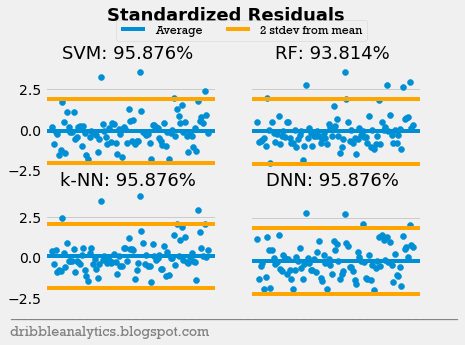

In [14]:
plt.style.use('fivethirtyeight')

residFig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharey = 'row')

x = np.arange(ytest.shape[0])
ax1.xaxis.set_visible(False)
ax2.xaxis.set_visible(False)
ax3.xaxis.set_visible(False)
ax4.xaxis.set_visible(False)

ax1.scatter(x, svrResid)
ax1.axhline(y = np.mean(svrResid), label = "Average")
ax1.axhline(y = np.mean(svrResid) - 2 * np.std(svrResid), color = 'orange')
ax1.axhline(y = np.mean(svrResid) + 2 * np.std(svrResid), label = "2 stdev from mean", color = 'orange')
ax1.set_title("SVM: %s" % outliers(svrResid), size = 18, x = .485, ha = 'center')

ax2.scatter(x, rfResid)
ax2.axhline(y = np.mean(rfResid))
ax2.axhline(y = np.mean(rfResid) - 2 * np.std(rfResid), color = 'orange')
ax2.axhline(y = np.mean(rfResid) + 2 * np.std(rfResid), color = 'orange')
ax2.set_title("RF: %s" % outliers(rfResid), size = 18, x = .485, ha = 'center')

ax3.scatter(x, knnResid)
ax3.axhline(y = np.mean(knnResid))
ax3.axhline(y = np.mean(knnResid) - 2 * np.std(knnResid), color = 'orange')
ax3.axhline(y = np.mean(knnResid) + 2 * np.std(knnResid), color = 'orange')
ax3.set_title("k-NN: %s" % outliers(knnResid), size = 18, x = .485, ha = 'center')

ax4.scatter(x, dnnResid)
ax4.axhline(y = np.mean(dnnResid))
ax4.axhline(y = np.mean(dnnResid) - 2 * np.std(dnnResid), color = 'orange')
ax4.axhline(y = np.mean(dnnResid) + 2 * np.std(dnnResid), color = 'orange')
ax4.set_title("DNN: %s" % outliers(dnnResid), size = 18, x = .485, ha = 'center')

residFig.legend(loc = (.25, .88), ncol=2, prop={'size': 12, "family": "Rockwell"})

residFig.suptitle("Standardized Residuals", weight = 'bold', size = 18, y = 1.08)

ax1.yaxis.set_ticks([-2.5, 0, 2.5])
ax3.yaxis.set_ticks([-2.5, 0, 2.5])

residFig.text(x = 0, y = 0,
    s = '________________________________________________________________',
    fontsize = 14, color = 'grey', horizontalalignment='left')

residFig.text(x = 0, y = -.06,
    s = 'dribbleanalytics.blogspot.com                     ',
    fontsize = 14, fontname = 'Rockwell', color = 'grey', horizontalalignment='left')

residFig.savefig('resid-fig.png', dpi = 400, bbox_inches = 'tight')

# Q-Q plot

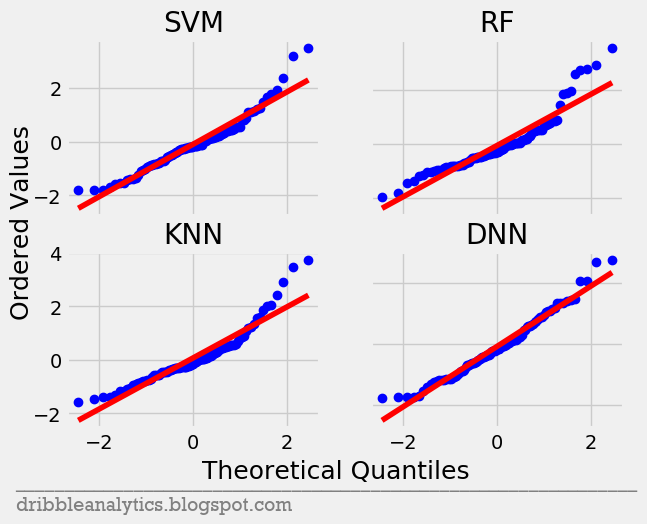

In [15]:
plt.rcParams.update(plt.rcParamsDefault)
plt.style.use('fivethirtyeight')

import scipy.stats as stats

qqplot = plt.figure()

ax1 = qqplot.add_subplot(221)
stats.probplot(svrResid, dist="norm", plot=plt)
ax1.set_xlabel("")
ax1.set_xticklabels([])
ax1.set_ylabel("")
ax1.set_title("SVM")

ax2 = qqplot.add_subplot(222)
stats.probplot(rfResid, dist="norm", plot=plt)
ax2.set_xlabel("")
ax2.set_xticklabels([])
ax2.set_ylabel("")
ax2.set_title("RF")
ax2.set_xticklabels([])
ax2.set_yticklabels([])

ax3 = qqplot.add_subplot(223)
stats.probplot(knnResid, dist="norm", plot=plt)
ax3.set_xlabel("")
ax3.set_ylabel("")
ax3.set_title("KNN")

ax4 = qqplot.add_subplot(224)
stats.probplot(dnnResid, dist = "norm", plot = plt)
ax4.set_xlabel("")
ax4.set_ylabel("")
ax4.set_title("DNN")
ax4.set_yticklabels([])

qqplot.text(0.5, -0.02, 'Theoretical Quantiles', ha='center', va='center', size = 18)
qqplot.text(0.01, 0.5, 'Ordered Values', ha='center', va='center', rotation='vertical', size = 18)

qqplot.text(x = 0, y = -0.05,
    s = '_______________________________________________________________',
    fontsize = 14, color = 'grey', horizontalalignment='left')

qqplot.text(x = 0, y = -.1,
    s = 'dribbleanalytics.blogspot.com                     ',
    fontsize = 14, fontname = 'Rockwell', color = 'grey', horizontalalignment='left')

qqplot.savefig('qqplot.png', dpi = 400, bbox_inches = 'tight')

# Shapiro-Wilk test

In [16]:
from scipy.stats import shapiro

print(shapiro(svrResid))
print(shapiro(rfResid))
print(shapiro(knnResid))
print(shapiro(dnnResid))

(0.942312479019165, 0.00033625084324739873)
(0.8795511722564697, 2.4402277176704956e-07)
(0.9018903970718384, 2.362543227718561e-06)
(0.9724786281585693, 0.0390751026570797)


# Durbin-Watson test 

In [17]:
from statsmodels.stats import stattools as stools

print(stools.durbin_watson(svrResid))
print(stools.durbin_watson(rfResid))
print(stools.durbin_watson(knnResid))
print(stools.durbin_watson(dnnResid))

1.767383245417488
1.8063703164540477
1.8486335445324737
1.6865329254892651


# Learning curve for MSE

In [18]:
from sklearn.model_selection import learning_curve

train_sizes = [1, 25, 50, 75, 100, 125, 150, 175, 200, 225, 250]


features = ['Team Wins', 'Overall Seed', 'PTS', 'TRB', 'AST', 'FG%', 'VORP', 'WS']
target = 'Share'

train_sizesSVR, train_scoresSVR, validation_scoresSVR = learning_curve(estimator = SVR(
    kernel='rbf', gamma=1e-4, C=100, epsilon = .1),
    X = dfHistorical[features], y = dfHistorical[target], train_sizes = train_sizes, cv = 3,
    scoring = 'neg_mean_squared_error')

In [19]:
train_sizesRF, train_scoresRF, validation_scoresRF = learning_curve(estimator = RandomForestRegressor(
    random_state = 9, n_estimators = 100, criterion = 'mse'),
    X = dfHistorical[features], y = dfHistorical[target], train_sizes = train_sizes, cv = 3,
    scoring = 'neg_mean_squared_error')

In [20]:
train_sizes1 = [7, 25, 50, 75, 100, 125, 150, 175, 200, 225, 250]

train_sizesKNN, train_scoresKNN, validation_scoresKNN = learning_curve(estimator = neighbors.KNeighborsRegressor(
    n_neighbors = 7, weights = 'uniform'),
    X = dfHistorical[features], y = dfHistorical[target], train_sizes = train_sizes1, cv = 3,
    scoring = 'neg_mean_squared_error')

In [21]:
train_sizesDNN, train_scoresDNN, validation_scoresDNN = learning_curve(estimator = MLPRegressor(
    solver='lbfgs',
    hidden_layer_sizes=100,
    max_iter=10000,
    random_state=987654321,
    activation='identity',
    learning_rate ='invscaling'),
    X = dfHistorical[features], y = dfHistorical[target], train_sizes = train_sizes, cv = 3,
    scoring = 'neg_mean_squared_error')

In [22]:
train_scores_meanSVR = -train_scoresSVR.mean(axis = 1)
validation_scores_meanSVR = -validation_scoresSVR.mean(axis = 1)

train_scores_meanRF = -train_scoresRF.mean(axis = 1)
validation_scores_meanRF = -validation_scoresRF.mean(axis = 1)

train_scores_meanKNN = -train_scoresKNN.mean(axis = 1)
validation_scores_meanKNN = -validation_scoresKNN.mean(axis = 1)

train_scores_meanDNN = -train_scoresDNN.mean(axis = 1)
validation_scores_meanDNN = -validation_scoresDNN.mean(axis = 1)

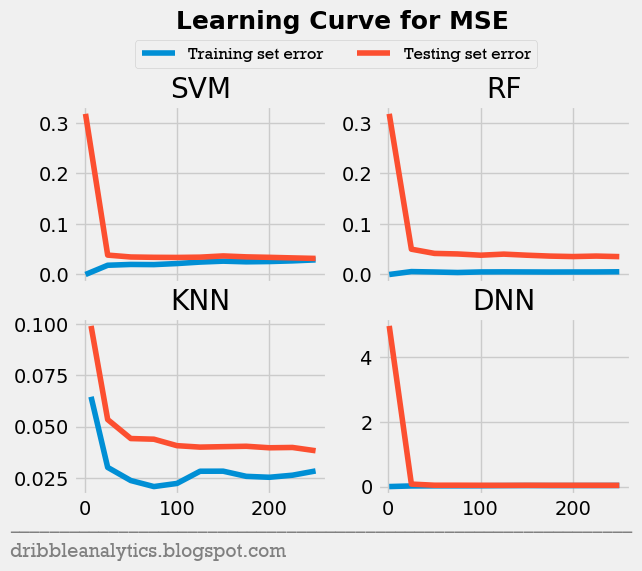

In [23]:
plt.rcParams.update(plt.rcParamsDefault)
plt.style.use('fivethirtyeight')

learningCurveMSE, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='col')

ax1.plot(train_sizesSVR, train_scores_meanSVR, label = 'Training set error')
ax1.plot(train_sizesSVR, validation_scores_meanSVR, label = 'Testing set error')
ax1.set_title("SVM")

ax2.plot(train_sizesRF, train_scores_meanRF)
ax2.plot(train_sizesRF, validation_scores_meanRF)
ax2.set_title("RF")

ax3.plot(train_sizesKNN, train_scores_meanKNN)
ax3.plot(train_sizesKNN, validation_scores_meanKNN)
ax3.set_title("KNN")

ax4.plot(train_sizesDNN, train_scores_meanDNN)
ax4.plot(train_sizesDNN, validation_scores_meanDNN)
ax4.set_title("DNN")

learningCurveMSE.suptitle("Learning Curve for MSE", weight = 'bold', size = 18, y = 1.08)
learningCurveMSE.legend(loc = (.21, .88), ncol=2, prop={'size': 12, "family": "Rockwell"})

learningCurveMSE.text(x = -0.02, y = 0,
    s = '_______________________________________________________________',
    fontsize = 14, color = 'grey', horizontalalignment='left')

learningCurveMSE.text(x = -0.02, y = -.06,
    s = 'dribbleanalytics.blogspot.com                     ',
    fontsize = 14, fontname = 'Rockwell', color = 'grey', horizontalalignment='left')

learningCurveMSE.savefig('learningCurveMSE.png', dpi = 400, bbox_inches = 'tight')

# Learning curve for R2

In [24]:
train_sizes = [1, 25, 50, 75, 100, 125, 150, 175, 200, 225, 250]

features = ['Team Wins', 'Overall Seed', 'PTS', 'TRB', 'AST', 'FG%', 'VORP', 'WS']
target = 'Share'

train_sizesSVR, train_scoresSVR, validation_scoresSVR = learning_curve(estimator = SVR(
    kernel='rbf', gamma=1e-4, C=100, epsilon = .1),
    X = dfHistorical[features], y = dfHistorical[target], train_sizes = train_sizes, cv = 3,
    scoring = 'r2')

In [25]:
train_sizesRF, train_scoresRF, validation_scoresRF = learning_curve(estimator = RandomForestRegressor(
    random_state = 9, n_estimators = 100, criterion = 'mse'),
    X = dfHistorical[features], y = dfHistorical[target], train_sizes = train_sizes, cv = 3,
    scoring = 'r2')

In [26]:
train_sizes1 = [7, 25, 50, 75, 100, 125, 150, 175, 200, 225, 250]

train_sizesKNN, train_scoresKNN, validation_scoresKNN = learning_curve(estimator = neighbors.KNeighborsRegressor(
    n_neighbors = 7, weights = 'uniform'),
    X = dfHistorical[features], y = dfHistorical[target], train_sizes = train_sizes1, cv = 3,
    scoring = 'r2')

In [27]:
train_sizesDNN, train_scoresDNN, validation_scoresDNN = learning_curve(estimator = MLPRegressor(
    solver='lbfgs',
    hidden_layer_sizes=100,
    max_iter=10000,
    random_state=987654321,
    activation='identity',
    learning_rate ='invscaling'),
    X = dfHistorical[features], y = dfHistorical[target], train_sizes = train_sizes, cv = 3,
    scoring = 'r2')

In [28]:
train_scores_meanSVR = train_scoresSVR.mean(axis = 1)
validation_scores_meanSVR = validation_scoresSVR.mean(axis = 1)

train_scores_meanRF = train_scoresRF.mean(axis = 1)
validation_scores_meanRF = validation_scoresRF.mean(axis = 1)

train_scores_meanKNN = train_scoresKNN.mean(axis = 1)
validation_scores_meanKNN = validation_scoresKNN.mean(axis = 1)

train_scores_meanDNN = train_scoresDNN.mean(axis = 1)
validation_scores_meanDNN = validation_scoresDNN.mean(axis = 1)

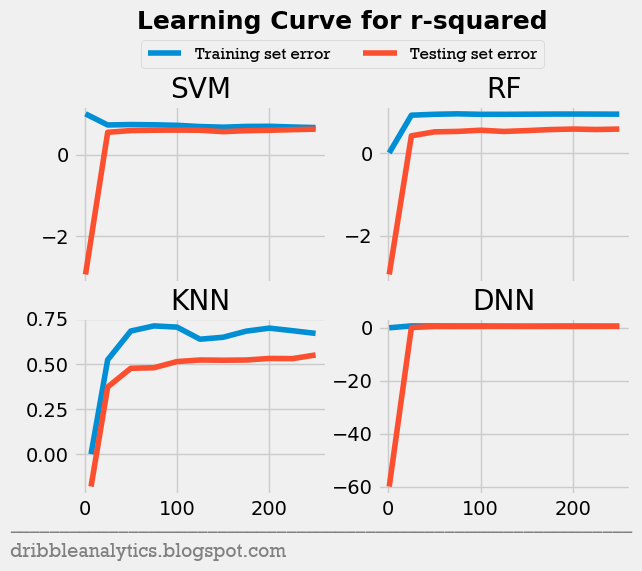

In [29]:
plt.style.use('fivethirtyeight')

learningCurveR2, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='col')

ax1.plot(train_sizesSVR, train_scores_meanSVR, label = 'Training set error')
ax1.plot(train_sizesSVR, validation_scores_meanSVR, label = 'Testing set error')
ax1.set_title("SVM")

ax2.plot(train_sizesRF, train_scores_meanRF)
ax2.plot(train_sizesRF, validation_scores_meanRF)
ax2.set_title("RF")

ax3.plot(train_sizesKNN, train_scores_meanKNN)
ax3.plot(train_sizesKNN, validation_scores_meanKNN)
ax3.set_title("KNN")

ax4.plot(train_sizesDNN, train_scores_meanDNN)
ax4.plot(train_sizesDNN, validation_scores_meanDNN)
ax4.set_title("DNN")

learningCurveR2.suptitle("Learning Curve for r-squared", weight = 'bold', size = 18, y = 1.08)
learningCurveR2.legend(loc = (.22, .88), ncol=2, prop={'size': 12, "family": "Rockwell"})

learningCurveR2.text(x = -0.02, y = 0,
    s = '_______________________________________________________________',
    fontsize = 14, color = 'grey', horizontalalignment='left')

learningCurveR2.text(x = -0.02, y = -.06,
    s = 'dribbleanalytics.blogspot.com                     ',
    fontsize = 14, fontname = 'Rockwell', color = 'grey', horizontalalignment='left')

learningCurveR2.savefig('learningCurveR2.png', dpi = 400, bbox_inches = 'tight')

# Prediction

In [30]:
dfCurrentNames = dfCurrent.iloc[:, 1]
dfCurrentPredict = dfCurrent[['Team Wins', 'Overall Seed', 'PTS', 'TRB', 'AST', 'FG%', 'VORP', 'WS']]

dfCurrent.head()

,Rank,Player,Age,Tm,G,Team Wins,Overall Seed,MP,PTS,TRB,...,FT%,WS,WS/48,VORP,BPM,G-Unadjusted,Wins-Unadjusted,WS-Unadjusted,VORP-Unadjusted,Total Games
0,1,Giannis (1),24,MIL,76.142857,58.571429,2,33.5,26.7,12.6,...,0.701,13.861905,0.261,7.419048,9.6,39,30,7.1,3.8,42
1,2,Harden (2),29,HOU,76.142857,46.857143,11,37.2,34.2,6.2,...,0.859,13.471429,0.229,9.371429,11.2,39,24,6.9,4.8,42
2,3,Curry (3),30,GSW,61.023256,55.302326,4,34.6,29.4,5.2,...,0.917,9.725581,0.221,4.767442,7.1,32,29,5.1,2.5,43
3,4,Kawhi (4),27,TOR,63.777778,60.133333,1,34.9,27.5,8.0,...,0.846,10.933333,0.238,4.191111,5.6,35,33,6.0,2.3,45
4,5,Jokic (5),23,DEN,82.000000,56.619048,3,31.4,19.7,10.2,...,0.837,12.300000,0.228,7.614286,9.7,42,29,6.3,3.9,42


## SVR 

In [31]:
svrPredict = svr.predict(dfCurrentPredict)
svrPredict = svrPredict.tolist()

for (i, j) in zip(dfCurrentNames, svrPredict):
    print(i, j)

Giannis (1) 0.6249103066305093
Harden (2) 0.469397808852305
Curry (3) 0.2709255099185679
Kawhi (4) 0.35153792309536236
Jokic (5) 0.36359415265613215
PG13 (6) 0.2010034591587111
Embiid (7) 0.19144298458014752
LeBron (8) 0.08304582659431325
KD (9) 0.3478675506080702
Davis (10) 0.20645977349951572


In [32]:
svrListUnsorted = [[i, j] for i, j in zip(dfCurrentNames, svrPredict)]
svrDataUnsorted = [row[1] for row in svrListUnsorted]
svrList = sorted(svrListUnsorted, key = itemgetter(1), reverse = True)

svrData = [row[1] for row in svrList]
svrNames = [row[0] for row in svrList]
print(svrList)

x_svr = np.arange(len(svrData))

[['Giannis (1)', 0.6249103066305093], ['Harden (2)', 0.469397808852305], ['Jokic (5)', 0.36359415265613215], ['Kawhi (4)', 0.35153792309536236], ['KD (9)', 0.3478675506080702], ['Curry (3)', 0.2709255099185679], ['Davis (10)', 0.20645977349951572], ['PG13 (6)', 0.2010034591587111], ['Embiid (7)', 0.19144298458014752], ['LeBron (8)', 0.08304582659431325]]


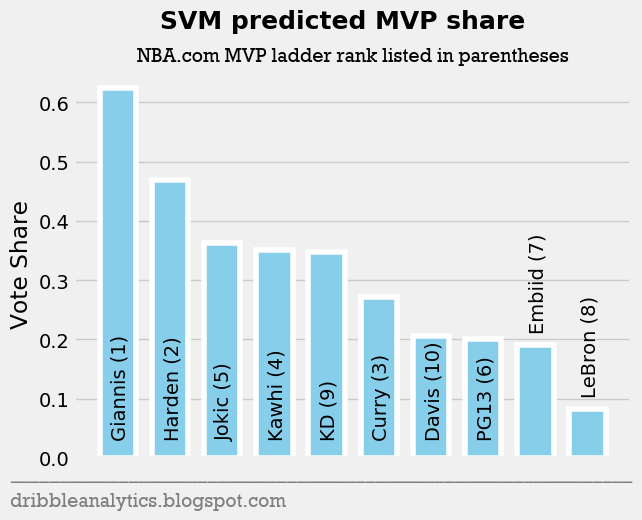

In [33]:
plt.style.use('fivethirtyeight')

svr, ax = plt.subplots()

ax.bar(x_svr, svrData, width = .7, edgecolor = 'white', color = 'skyblue', linewidth = 4, label = 'Predicted')

labels = svrNames

rects = ax.patches
for rect, label in zip(rects, labels):
    if rect.get_x() > 7:
        ax.text(rect.get_x() + rect.get_width() / 1.75, rect.get_height() + .02, label,
        ha='center', va='bottom', rotation = 'vertical', color = 'black')
    elif rect.get_x() <=7:
        height = .03
        ax.text(rect.get_x() + rect.get_width() / 1.75, height, label,
        ha='center', va='bottom', rotation = 'vertical', color = 'black')
    
svr.suptitle("SVM predicted MVP share", weight = 'bold', size = 18, y = 1.005)
ax.set_title("NBA.com MVP ladder rank listed in parentheses", size = 14, fontname = 'Rockwell')
ax.xaxis.set_visible(False)
ax.set_ylabel("Vote Share")

svr.text(x = -0.02, y = 0.03,
    s = '_______________________________________________________________',
    fontsize = 14, color = 'grey', horizontalalignment='left')

svr.text(x = -0.02, y = -.03,
    s = 'dribbleanalytics.blogspot.com                     ',
    fontsize = 14, fontname = 'Rockwell', color = 'grey', horizontalalignment='left')

svr.savefig('svr.png', dpi = 400, bbox_inches = 'tight')

## RF

In [34]:
rfPredict = rf.predict(dfCurrentPredict)
rfPredict = rfPredict.tolist()

for (i, j) in zip(dfCurrentNames, rfPredict):
    print(i, j)

Giannis (1) 0.6479300000000002
Harden (2) 0.37871999999999995
Curry (3) 0.25941
Kawhi (4) 0.20261000000000007
Jokic (5) 0.2762599999999999
PG13 (6) 0.20545000000000002
Embiid (7) 0.23493000000000014
LeBron (8) 0.14764
KD (9) 0.18072999999999997
Davis (10) 0.34305


In [35]:
rfListUnsorted = [[i, j] for i, j in zip(dfCurrentNames, rfPredict)]
rfDataUnsorted = [row[1] for row in rfListUnsorted]
rfList = sorted(rfListUnsorted, key = itemgetter(1), reverse = True)

rfData = [row[1] for row in rfList]
rfNames = [row[0] for row in rfList]
print(rfList)

x_rf = np.arange(len(rfData))

[['Giannis (1)', 0.6479300000000002], ['Harden (2)', 0.37871999999999995], ['Davis (10)', 0.34305], ['Jokic (5)', 0.2762599999999999], ['Curry (3)', 0.25941], ['Embiid (7)', 0.23493000000000014], ['PG13 (6)', 0.20545000000000002], ['Kawhi (4)', 0.20261000000000007], ['KD (9)', 0.18072999999999997], ['LeBron (8)', 0.14764]]


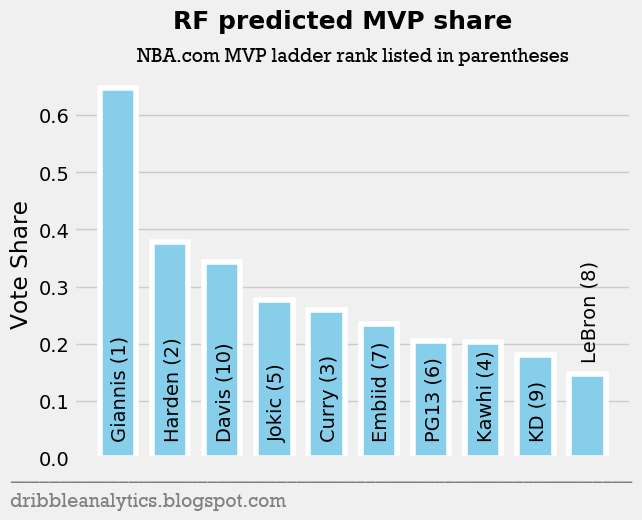

In [36]:
plt.style.use('fivethirtyeight')

rf, ax = plt.subplots()

ax.bar(x_rf, rfData, width = .7, edgecolor = 'white', color = 'skyblue', linewidth = 4, label = 'Predicted')

labels = rfNames

rects = ax.patches
for rect, label in zip(rects, labels):
    if rect.get_x() > 8:
        ax.text(rect.get_x() + rect.get_width() / 1.75, rect.get_height() + .02, label,
        ha='center', va='bottom', rotation = 'vertical', color = 'black')
    elif rect.get_x() <= 8:
        height = .03
        ax.text(rect.get_x() + rect.get_width() / 1.75, height, label,
        ha='center', va='bottom', rotation = 'vertical', color = 'black')
        
rf.suptitle("RF predicted MVP share", weight = 'bold', size = 18, y = 1.005)
ax.set_title("NBA.com MVP ladder rank listed in parentheses", size = 14, fontname = 'Rockwell')
ax.xaxis.set_visible(False)
ax.set_ylabel("Vote Share")

rf.text(x = -0.02, y = 0.03,
    s = '_______________________________________________________________',
    fontsize = 14, color = 'grey', horizontalalignment='left')

rf.text(x = -0.02, y = -.03,
    s = 'dribbleanalytics.blogspot.com                     ',
    fontsize = 14, fontname = 'Rockwell', color = 'grey', horizontalalignment='left')

rf.savefig('rf.png', dpi = 400, bbox_inches = 'tight')

## k-NN

In [37]:
knnPredict = knn.predict(dfCurrentPredict)
knnPredict = knnPredict.tolist()

for (i, j) in zip(dfCurrentNames, knnPredict):
    print(i, j)

Giannis (1) 0.5315714285714286
Harden (2) 0.3862857142857143
Curry (3) 0.25614285714285717
Kawhi (4) 0.25042857142857144
Jokic (5) 0.3188571428571429
PG13 (6) 0.13314285714285715
Embiid (7) 0.17657142857142857
LeBron (8) 0.1362857142857143
KD (9) 0.18671428571428575
Davis (10) 0.11742857142857142


In [38]:
knnListUnsorted = [[i, j] for i, j in zip(dfCurrentNames, knnPredict)]
knnDataUnsorted = [row[1] for row in knnListUnsorted]
knnList = sorted(knnListUnsorted, key = itemgetter(1), reverse = True)

knnData = [row[1] for row in knnList]
knnNames = [row[0] for row in knnList]
print(knnList)

x_knn = np.arange(len(knnData))

[['Giannis (1)', 0.5315714285714286], ['Harden (2)', 0.3862857142857143], ['Jokic (5)', 0.3188571428571429], ['Curry (3)', 0.25614285714285717], ['Kawhi (4)', 0.25042857142857144], ['KD (9)', 0.18671428571428575], ['Embiid (7)', 0.17657142857142857], ['LeBron (8)', 0.1362857142857143], ['PG13 (6)', 0.13314285714285715], ['Davis (10)', 0.11742857142857142]]


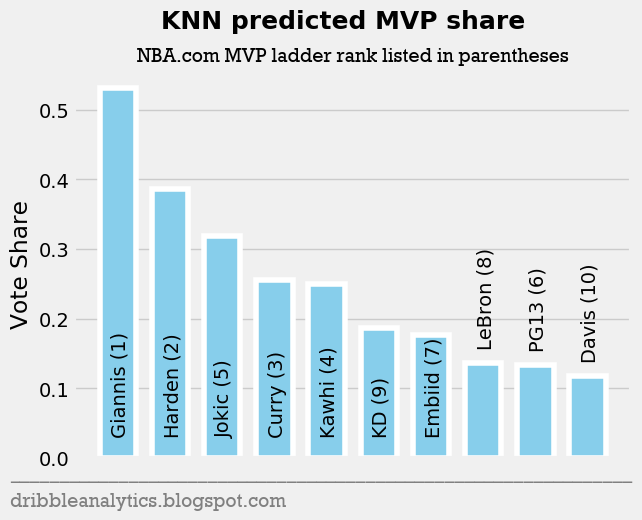

In [39]:
plt.style.use('fivethirtyeight')

knn, ax = plt.subplots()

ax.bar(x_knn, knnData, width = .7, edgecolor = 'white', color = 'skyblue', linewidth = 4, label = 'Predicted')

labels = knnNames

rects = ax.patches
for rect, label in zip(rects, labels):
    if rect.get_x() > 6:
        ax.text(rect.get_x() + rect.get_width() / 1.75, rect.get_height() + .02, label,
        ha='center', va='bottom', rotation = 'vertical', color = 'black')
    elif rect.get_x() <= 6:
        height = .03
        ax.text(rect.get_x() + rect.get_width() / 1.75, height, label,
        ha='center', va='bottom', rotation = 'vertical', color = 'black')
        
knn.suptitle("KNN predicted MVP share", weight = 'bold', size = 18, y = 1.005)
ax.set_title("NBA.com MVP ladder rank listed in parentheses", size = 14, fontname = 'Rockwell')
ax.xaxis.set_visible(False)
ax.set_ylabel("Vote Share")

knn.text(x = -0.02, y = 0.03,
    s = '_______________________________________________________________',
    fontsize = 14, color = 'grey', horizontalalignment='left')

knn.text(x = -0.02, y = -.03,
    s = 'dribbleanalytics.blogspot.com                     ',
    fontsize = 14, fontname = 'Rockwell', color = 'grey', horizontalalignment='left')

knn.savefig('knn.png', dpi = 400, bbox_inches = 'tight')

## DNN

In [40]:
dnnPredict = dnn.predict(dfCurrentPredict)
dnnPredict = dnnPredict.tolist()

for (i, j) in zip(dfCurrentNames, dnnPredict):
    print(i, j)

Giannis (1) 0.5307999858884165
Harden (2) 0.4982719023582851
Curry (3) 0.2529734189153756
Kawhi (4) 0.32419879921355776
Jokic (5) 0.3498133844354776
PG13 (6) 0.27777396453958114
Embiid (7) 0.2759730670354019
LeBron (8) 0.07795651226714752
KD (9) 0.38428010335063667
Davis (10) 0.27034720670859724


In [41]:
dnnListUnsorted = [[i, j] for i, j in zip(dfCurrentNames, dnnPredict)]
dnnDataUnsorted = [row[1] for row in dnnListUnsorted]
dnnList = sorted(dnnListUnsorted, key = itemgetter(1), reverse = True)

dnnData = [row[1] for row in dnnList]
dnnNames = [row[0] for row in dnnList]
print(dnnList)

x_dnn = np.arange(len(dnnData))

[['Giannis (1)', 0.5307999858884165], ['Harden (2)', 0.4982719023582851], ['KD (9)', 0.38428010335063667], ['Jokic (5)', 0.3498133844354776], ['Kawhi (4)', 0.32419879921355776], ['PG13 (6)', 0.27777396453958114], ['Embiid (7)', 0.2759730670354019], ['Davis (10)', 0.27034720670859724], ['Curry (3)', 0.2529734189153756], ['LeBron (8)', 0.07795651226714752]]


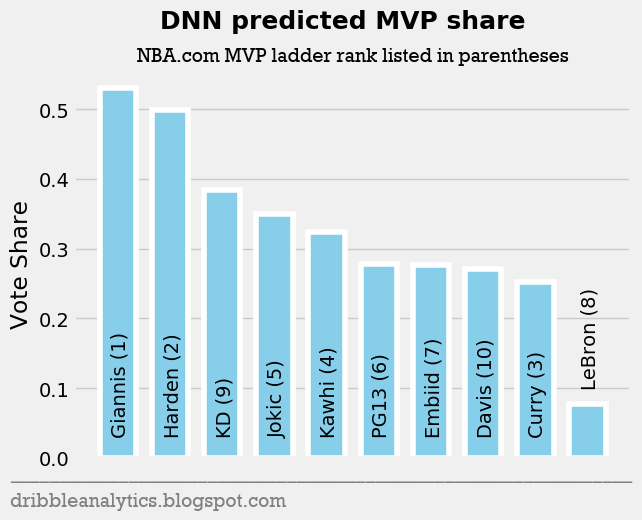

In [42]:
plt.style.use('fivethirtyeight')

dnn, ax = plt.subplots()

ax.bar(x_dnn, dnnData, width = .7, edgecolor = 'white', color = 'skyblue', linewidth = 4, label = 'Predicted')

labels = dnnNames

rects = ax.patches
for rect, label in zip(rects, labels):
    if rect.get_x() > 8:
        ax.text(rect.get_x() + rect.get_width() / 1.75, rect.get_height() + .02, label,
        ha='center', va='bottom', rotation = 'vertical', color = 'black')
    elif rect.get_x() <= 8:
        height = .03
        ax.text(rect.get_x() + rect.get_width() / 1.75, height, label,
        ha='center', va='bottom', rotation = 'vertical', color = 'black')
        
dnn.suptitle("DNN predicted MVP share", weight = 'bold', size = 18, y = 1.005)
ax.set_title("NBA.com MVP ladder rank listed in parentheses", size = 14, fontname = 'Rockwell')
ax.xaxis.set_visible(False)
ax.set_ylabel("Vote Share")

dnn.text(x = -0.02, y = 0.03,
    s = '_______________________________________________________________',
    fontsize = 14, color = 'grey', horizontalalignment='left')

dnn.text(x = -0.02, y = -.03,
    s = 'dribbleanalytics.blogspot.com                     ',
    fontsize = 14, fontname = 'Rockwell', color = 'grey', horizontalalignment='left')

dnn.savefig('dnn.png', dpi = 400, bbox_inches = 'tight')

## Average

In [43]:
avgPredict = []

for (i, j, h, k) in zip(svrDataUnsorted, rfDataUnsorted, knnDataUnsorted, dnnDataUnsorted):
    avgPredict.append((i + j + h + k) / 4)

avgList = [[i, j] for i, j in zip(dfCurrentNames, avgPredict)]
avgList = sorted(avgList, key = itemgetter(1), reverse = True)

avgData = [row[1] for row in avgList]
avgNames = [row[0] for row in avgList]
print(avgList)

x_avg = np.arange(len(avgData))

[['Giannis (1)', 0.5838029302725887], ['Harden (2)', 0.4331688563740761], ['Jokic (5)', 0.32713116998718816], ['Kawhi (4)', 0.28219382343437294], ['KD (9)', 0.27489798491824813], ['Curry (3)', 0.25986294649420016], ['Davis (10)', 0.23432138790917112], ['Embiid (7)', 0.21972937004674453], ['PG13 (6)', 0.20434257021028734], ['LeBron (8)', 0.11123201328679376]]


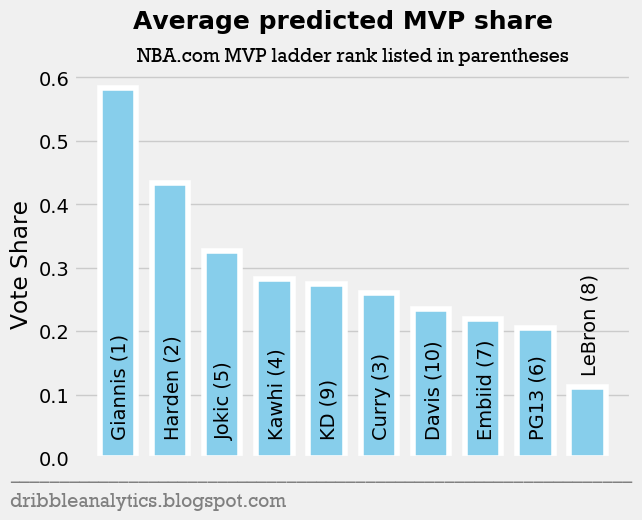

In [44]:
plt.style.use('fivethirtyeight')

avg, ax = plt.subplots()

ax.bar(x_avg, avgData, width = .7, edgecolor = 'white', color = 'skyblue', linewidth = 4, label = 'Predicted')

labels = avgNames

rects = ax.patches
for rect, label in zip(rects, labels):
    if rect.get_x() > 8:
        ax.text(rect.get_x() + rect.get_width() / 1.75, rect.get_height() + .02, label,
        ha='center', va='bottom', rotation = 'vertical', color = 'black')
    elif rect.get_x() <= 8:
        height = .03
        ax.text(rect.get_x() + rect.get_width() / 1.75, height, label,
        ha='center', va='bottom', rotation = 'vertical', color = 'black')
        
avg.suptitle("Average predicted MVP share", weight = 'bold', size = 18, y = 1.005)
ax.set_title("NBA.com MVP ladder rank listed in parentheses", size = 14, fontname = 'Rockwell')
ax.xaxis.set_visible(False)
ax.set_ylabel("Vote Share")

avg.text(x = -0.02, y = 0.03,
    s = '_______________________________________________________________',
    fontsize = 14, color = 'grey', horizontalalignment='left')

avg.text(x = -0.02, y = -.03,
    s = 'dribbleanalytics.blogspot.com                     ',
    fontsize = 14, fontname = 'Rockwell', color = 'grey', horizontalalignment='left')

avg.savefig('avg.png', dpi = 400, bbox_inches = 'tight')